In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)

# 1. **Рекомендации в онлайн магазине**
Есть онлайн магазин, в котором продаются мобильные телефоны и комплектующие (наушники, зарядки, чехлы и т.д.). На странице просмотра телефона был блок рекомендаций с похожими моделями и аксессуарами. В рамках сотрудничеста с компанией делающей чехлы с уникальными рисунками, решили попробовать заменить блок рекомендаций на рекламу чехлов этой компании.

**Гипотеза:**
1. изменили блок рекомендаций на рекомендации красивых чехлов
2. ожидаем что это приведёт к увеличению продаж аксессуаров
3. сможем увидеть это по метрике - средняя выручка от продажи аксессуаров

В качестве метрики взяли продажи всех аксессуаров, а не только чехлов, тк реклама именно чехлов может каннибализировать продажу других видов аксессуаров.

**Дополнительные метрики:**
- продажи чехлов - чтобы понимать, что чехлы продаются и интересны покупателям;
- продажи других аксессуаров - реклама только чехлов может каннибализировать продажи других аксессуаров;
- трафик (кол-во покупателей на кол-во сессий просмотра сайта) - вдруг наше изменение будут настолько плохим, что покупателей станет меньше;
- средний чек - возможно наше изменение стимулирует увеличение покупок чехлов, что увеличит средний чек;
- суммарные продажи телефонов и аксессуаров - может быть так, что трафик уменьшится, но средний чек увеличится, и суммарная выручка не упадёт.

**Пилот**:
- случайно разбиваем пользователей, зашедших на сайт, в контрольную или пилотную группы;
- в контрольной группе показываем старые рекомендации, в пилотной - новые;
- ждём 14 дней;
- за это время в группах оказалось по 110523 пользовательских сессии.

## Загрузим данные

Заметим, что в представленной базе данных уже проведена фильтрация сессий без покупок. Они сейчас не существенны, про их значение мы поговорим чуть позже.

In [48]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name, index_col=0)

In [49]:
data = read_database('sem2_task1.csv')

print(f'data shape : {data.shape}')
data.head(10)

data shape : (6452, 5)


,day,cost_phones,cost_cases,cost_accessories,group
0,1,21900,2300,3300,control
1,1,43400,0,0,control
2,1,31500,0,0,control
3,1,31000,0,0,control
4,1,50400,2300,5100,control
5,1,59000,0,0,control
6,1,31200,2200,0,control
7,1,37700,0,2700,control
8,1,20000,1500,0,control
9,1,39200,0,0,control


Для начала мы можем посмотреть на простую, но вместе с тем красивую картинку. В пилотной группе трафик больше, чем в контрольной.

/var/folders/nh/hpqm4c910xb8tsrb1y2n3ymr0000gn/T/ipykernel_82278/1977566777.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='group', data=data, palette='hls')


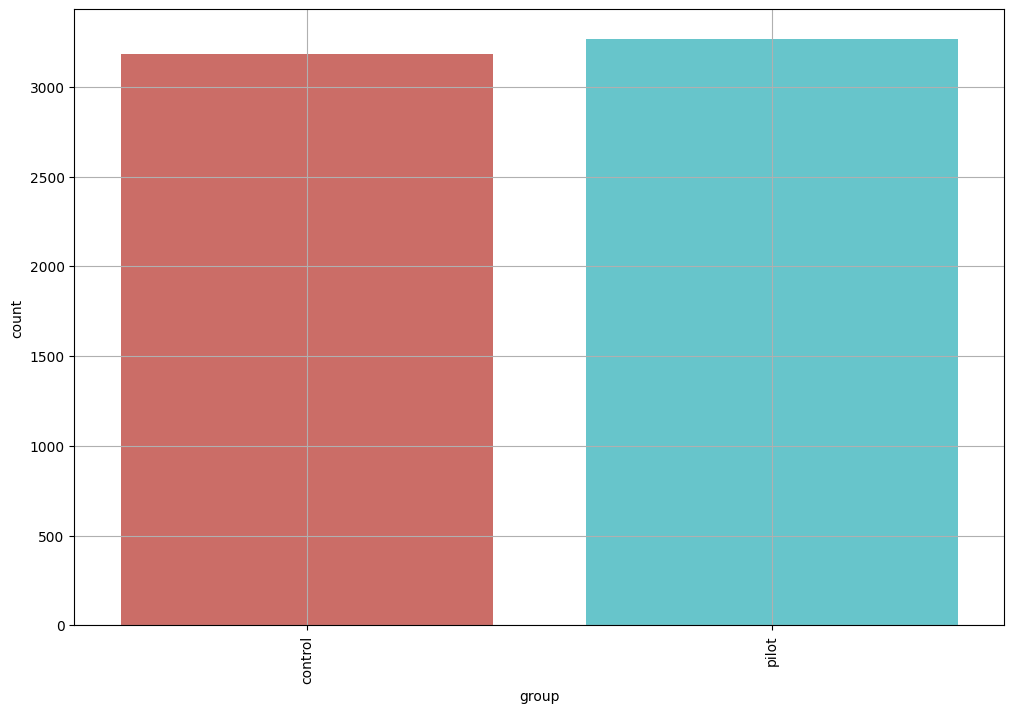

In [6]:
sns.countplot(x='group', data=data, palette='hls')
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Дашборд эксперимента

Вообще говоря нехорошо в процессе эксперимента подглядывать в данные. Тут можно долго говорить про эффект наблюдателя. Не хорошо, но иногда очень хочется.

Просто убедимся, что в процессе запуска эксперимента мы не допустили катострофических ошибок -- метрики не упали в ноль.

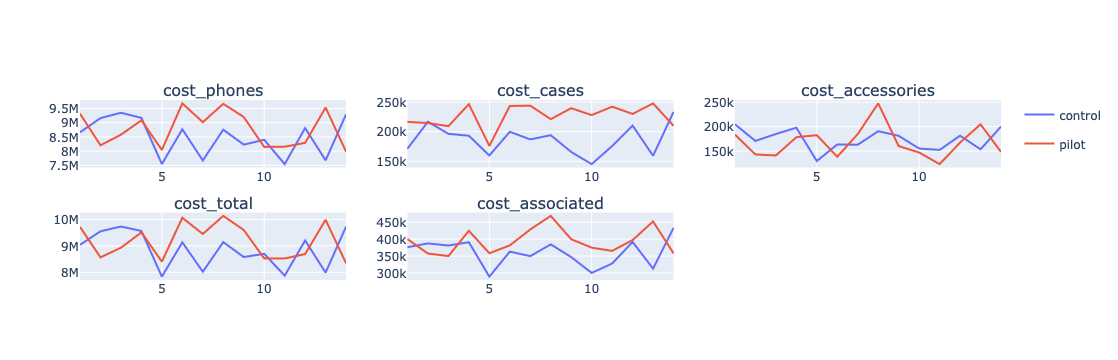

In [47]:
data_sint = data.copy()
data_sint['cost_total'] = data[['cost_phones', 'cost_cases', 'cost_accessories']].sum(axis=1)
data_sint['cost_associated'] = data[['cost_cases', 'cost_accessories']].sum(axis=1)
cost_columns = [c for c in data_sint.columns if 'cost' in c]

fig = make_subplots(
    rows=2, cols=3, subplot_titles=cost_columns
    )

for column, ax in zip(cost_columns, range(1, len(cost_columns)+1)):
    data_groupby = data_sint.groupby(['day', 'group'])[[column]].sum().reset_index()
    fig_t = px.line(data_groupby, x='day', y=column, color='group', title=column)
    if ax < 4:
        row, col = 1, ax
    else:
        row, col = 2, ax-3
    for i in fig_t.data:
        fig.add_trace(i, row=row, col=col)
    data_pivot = data_groupby.pivot(index='day', columns='group', values=column)
        
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))
fig.show()

## Визуальное сравнение распределений

Давайте немного подробней посмотрим на статистики. Для этого построим гистограммы по всем метрикам.

In [50]:
print(data_sint['group'].value_counts(), '\n')

for column in data_sint.drop('group', axis=1).columns:
    print(column)
    for group in ['control', 'pilot']:
        data_ = data_sint[data_sint['group']==group][column]
        print('  ', round(data_.mean(), 2), data_.nunique(), data_.min(), data_.max())

pilot      3267
control    3185
Name: group, dtype: int64 

day
   7.41 14 1 14
   7.46 14 1 14
cost_phones
   37376.39 724 4100 100800
   37622.87 735 4100 104100
cost_cases
   818.68 36 0 4200
   969.39 38 0 4000
cost_accessories
   762.39 55 0 6500
   719.19 57 0 6300
cost_total
   38957.46 740 4100 101900
   39311.45 745 4100 105900
cost_associated
   1581.07 75 0 8100
   1688.58 78 0 8900


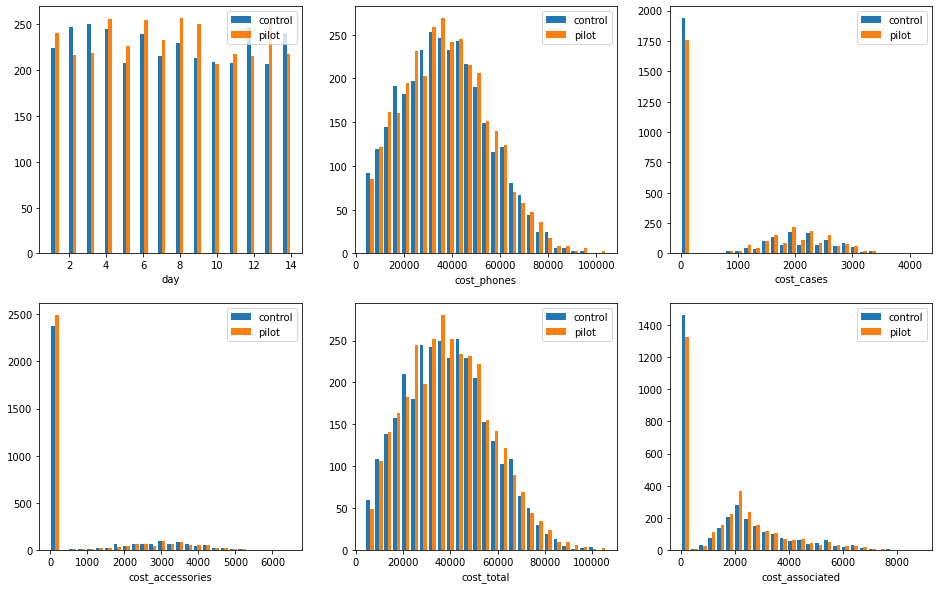

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for column, ax in zip(data_sint.drop('group', axis=1).columns,
                      ax.flatten()):
    ax.set_xlabel(column)
    data_pilot = data_sint[data_sint['group'] == 'pilot'][column].values
    data_control = data_sint[data_sint['group'] == 'control'][column].values
    bins = np.linspace(data_sint[column].min(), data_sint[column].max(), 28)
    ax.hist([data_control, data_pilot], bins, label=['control', 'pilot'])
    ax.legend()
plt.show()

## Вычисление метрик

Давайте попробуем посмотреть на числа. Всё же статистика -- наука о числах, а не про картинки. Прежде всего нам надо посчитать общие значения метрик по нашим группам. Для этого в [Pandas](https://pandas.pydata.org/) есть много удобных и полезных функций. Для группировки данных нам понадобиться функция [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html):

```
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, 
    group_keys=True, squeeze=<object object>, observed=False, dropna=True)
```
а для сбора агрегированной статистики можно воспользоваться [pandas.DataFrame.aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html):
```
DataFrame.aggregate(func=None, axis=0, *args, **kwargs)
```

Подсчитаем трафик в каждой из групп, а так же суммарные расходы по каждому виду товаров:

In [52]:
data_grouped = data_sint.groupby('group').agg(
    traffic = ('group', 'count'),
    revenue_phones = ('cost_phones', 'sum'),
    revenue_cases = ('cost_cases', 'sum'),
    revenue_accessories = ('cost_accessories', 'sum'),
    revenue_assosiated = ('cost_associated', 'sum')
)

data_grouped

,traffic,revenue_phones,revenue_cases,revenue_accessories,revenue_assosiated
group,,,,,
control,3185,119043800,2607500,2428200,5035700
pilot,3267,122913900,3167000,2349600,5516600


Построим визуальное отображение для выручки по группам товаров:

<AxesSubplot:>

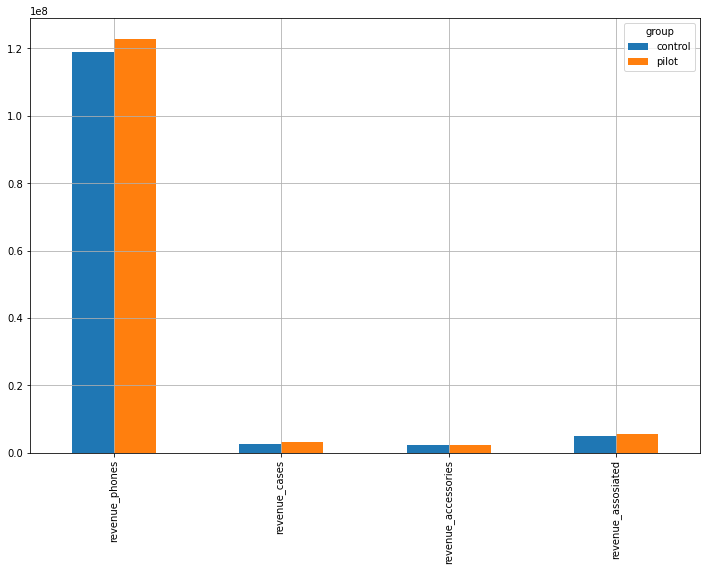

In [53]:
revenue = data_grouped[[col for col in data_grouped.columns if 'revenue' in col]].T
revenue.plot(kind='bar', grid=True)

График немного неинформативен из-за значительной разницы в масштабе. Но мы можем добавить магии matplotlib и симулировать разрыв в вертикальной оси:

<AxesSubplot:>

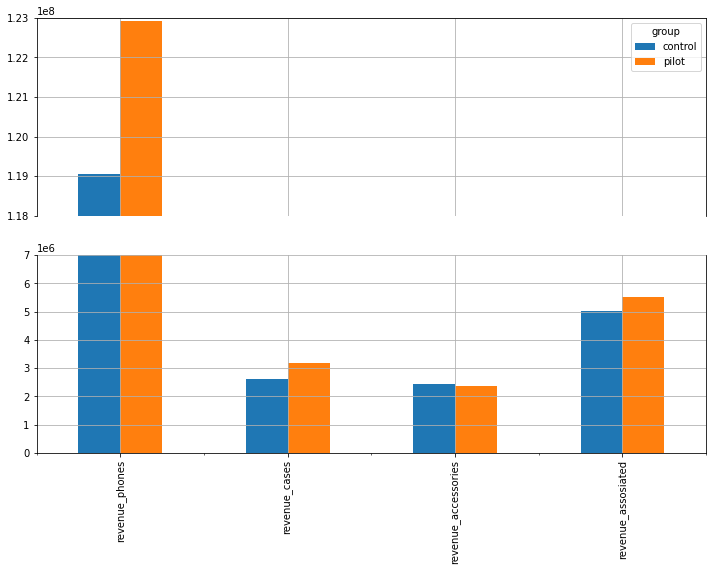

In [54]:
# https://stackoverflow.com/questions/53642861/broken-axis-slash-marks-inside-bar-chart-in-matplotlib

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 7 * 10 ** 6)
ax1.set_ylim(118 * 10 ** 6, 123 * 10 ** 6)

revenue.plot(ax=ax1, kind='bar', grid=True)
revenue.plot(ax=ax2, kind='bar', legend=False, grid=True)

Мы видим, что наша целевая метрика -- выручка по чехлам -- выросла. 
Немного просела выручка по аксессуарам, но падение незначительное.
Но главное в том, что значительно вырос основной показатель -- продажи мобильных телефонов. То есть цель выглядит достигнутой...

Так же мы можем посмотреть как на величину среднего чека, так и на средние значения по группам.

In [55]:
data_sint.groupby('group')[cost_columns].mean().astype(int)

,cost_phones,cost_cases,cost_accessories,cost_total,cost_associated
group,,,,,
control,37376,818,762,38957,1581
pilot,37622,969,719,39311,1688


Средний чек в пилотной группе меньше только по аксессуарам без учёта чехлов (cost_accessories), по остальным группам средний чек в пилотной группе стал больше.

## Проверка стат значимости

НО! Решения не принимаются на глаз. Человек склонен ошибаться и выдавать желаемое за действительное. Давайте считать статзначимость!

Проверим статистическую значимость отличий продаж по разным группам товаров.

Учтём, что в группах было по 110523 пользовательских сессий, а покупок чуть больше 3000 в каждой из групп. Соответственно, все сессии без покупок заполним нулями.

In [56]:
GROUP_SIZE = 110_523

for column in cost_columns:
    print(column)
    a_values_nonzero = data_sint[data_sint['group'] == 'control'][column].values
    b_values_nonzero = data_sint[data_sint['group'] == 'pilot'][column].values
    
    a_values = np.zeros(GROUP_SIZE)
    b_values = np.zeros(GROUP_SIZE)
    a_values[:len(a_values_nonzero)] = a_values_nonzero
    b_values[:len(b_values_nonzero)] = b_values_nonzero
    
    delta = b_values.mean() - a_values.mean()
    _, pvalue = stats.mannwhitneyu(a_values, b_values, alternative='less')
    print(f'  delta = {round(delta, 2)}')
    print(f'  pvalue = {round(pvalue, 3)}', '- значимо' if pvalue < 0.05 else '')

cost_phones
  delta = 35.02
  pvalue = 0.148 
cost_cases
  delta = 5.06
  pvalue = 0.0 - значимо
cost_accessories
  delta = -0.71
  pvalue = 0.83 
cost_total
  delta = 39.37
  pvalue = 0.147 
cost_associated
  delta = 4.35
  pvalue = 0.0 - значимо


Получили, что целевая метрика cost_cases_accessories статистически значимо увеличилась. Большинство контрольных метрик согласуются с гипотезой. Продажи прочих аксессуаров упали, но статистически не значимо, возможная причина - каннибализация. Это не критично, тк в сумме продажи прочих аксессуаров и чехлов выросли.